# Data Cleaning

In [1]:
import pandas as pd
df = pd.read_csv(r'D:\battery_aging\discharge.csv')
print(df)

        Voltage_measured  Current_measured  Temperature_measured  \
0               3.974871         -2.012528             24.389085   
1               3.951717         -2.013979             24.544752   
2               3.934352         -2.011144             24.731385   
3               3.920058         -2.013007             24.909816   
4               3.907904         -2.014400             25.105884   
...                  ...               ...                   ...   
169761          2.835283         -2.011160             37.396003   
169762          2.774711         -2.011370             37.544067   
169763          2.690974         -2.010542             37.723665   
169764          2.566085         -2.011117             37.925675   
169765          2.365585         -2.011110             38.143742   

        Current_charge  Voltage_charge      Time  Capacity  id_cycle  \
0               1.9982           3.062    35.703  1.856487         1   
1               1.9982           3.030 

In [2]:
print(df['Voltage_measured'])

0         3.974871
1         3.951717
2         3.934352
3         3.920058
4         3.907904
            ...   
169761    2.835283
169762    2.774711
169763    2.690974
169764    2.566085
169765    2.365585
Name: Voltage_measured, Length: 169766, dtype: float64


# SOC Estimation via Coloumb Counting

In [3]:
#0 to 354
fullyChargedVoltage = df['Voltage_measured'][0]
fullyDischargedVoltage = df['Voltage_measured'][178]
print("Charged Voltage : ", fullyChargedVoltage)
print("Discharged Voltage : ", fullyDischargedVoltage)

Charged Voltage :  3.974870912
Discharged Voltage :  3.979156705


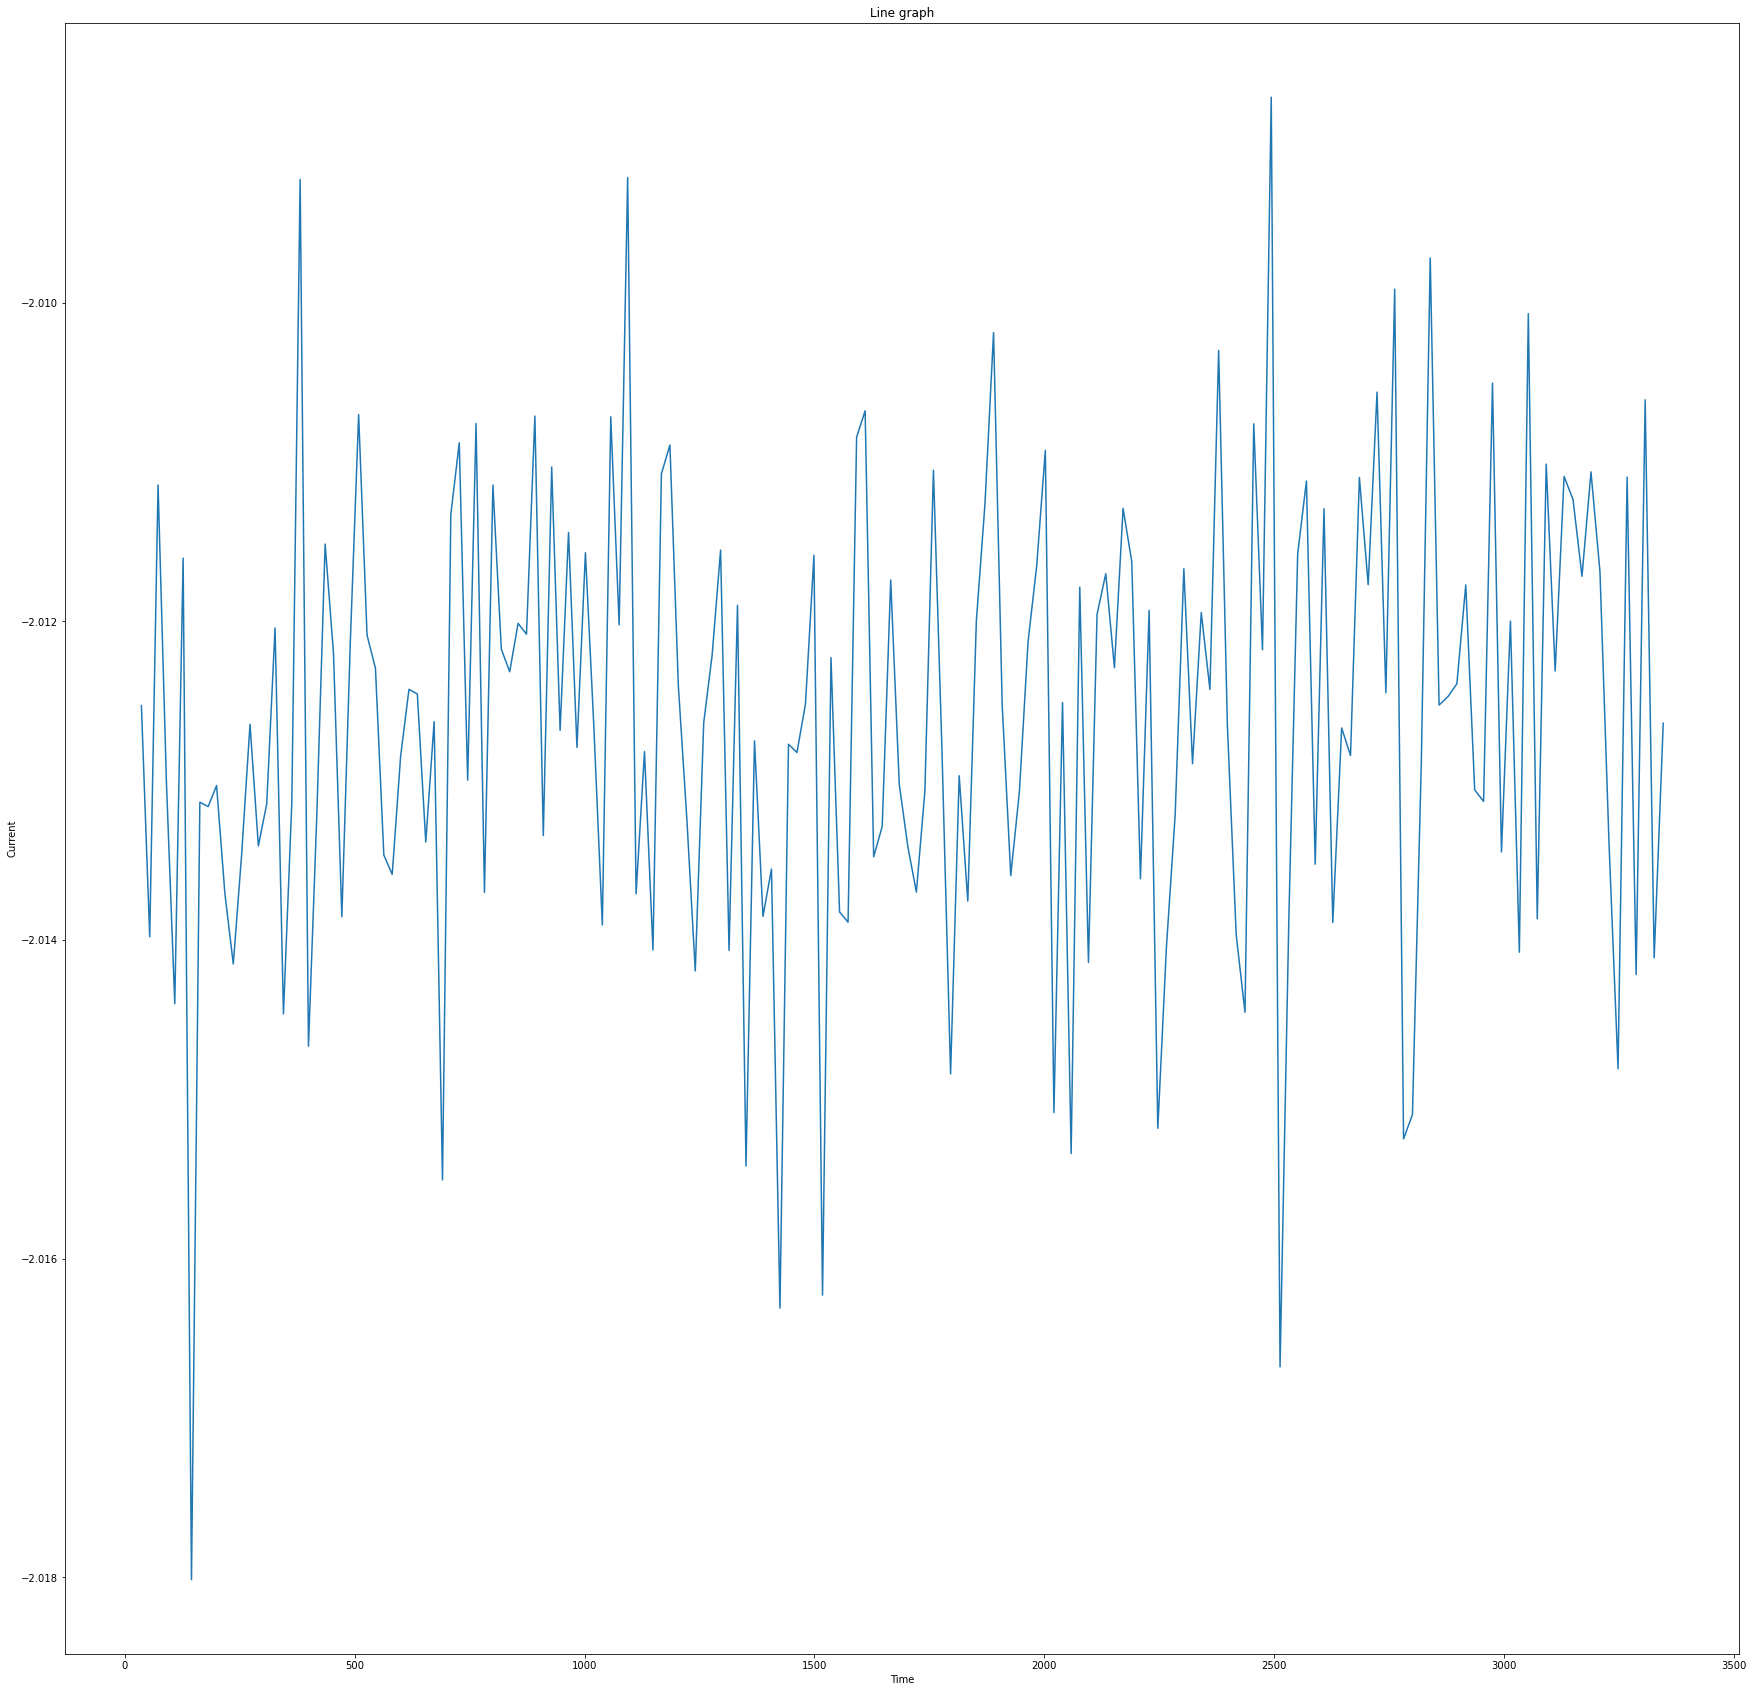

In [4]:
from matplotlib import pyplot as plt    
    
y = df['Current_measured'][0:178]    
x = df['Time'][0:178]    
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)    
plt.plot(x,y)    
    
plt.title("Line graph")    
plt.ylabel('Current')    
plt.xlabel('Time')    
plt.show() 

In [5]:
N = 178
Capacity = 1.856487
SOC_List = [100]
lst = []
rsArea = 0
for n in range(1, N+1):
    timeDiff = abs(df['Time'][n] - df['Time'][n-1])
    if(timeDiff > 25):
        timeDiff = sum(lst)/len(lst)
    lst.append(timeDiff)
    rsArea = rsArea + abs(timeDiff*df['Current_measured'][n])
print("RiemanSums Area : ", rsArea)
avgTime = sum(lst)/len(lst)

RiemanSums Area :  6701.938336048373


In [6]:
import numpy as np
from scipy.integrate import simpson
from numpy import trapz
y = np.array(list(df['Current_charge']))

area1 = trapz(y, dx=avgTime)
print("area =", area1)

# Compute the area using the composite Simpson's rule.
area2 = simpson(y, dx=avgTime)
print("area =", area2)
area = (area1 + area2)/2
area = abs(area) 
area

area = 6348592.31510159
area = 6348592.315101589


6348592.31510159

In [7]:
SOC_List = [100]
SOC_remaining = [0]
Capacity = df['Capacity'][0]*3600
for n in range(1, 178):
    timeDiff = abs(df['Time'][n] - df['Time'][n-1])
    if(timeDiff > 25):
        timeDiff = sum(lst)/len(lst)
    SOC_n = SOC_List[n-1] + df['Current_measured'][n]*(abs(timeDiff))*100/Capacity
    SOC_List.append(SOC_n)
    SOC_remaining.append(100 - SOC_n)
    
i = 0
print("Voltage,                   SOC")
for soc in SOC_List:
    print(df['Voltage_measured'][i], "       ",soc)
    i = i + 1

Voltage,                   SOC
3.974870912         100
3.951716708         99.45523288145618
3.934352489         98.90933703232706
3.920058442         98.36200177928966
3.90790351         97.81383565432931
3.897035722         97.26688207814256
3.887476581         96.71770202250865
3.878958592         96.16939816185126
3.871015985         95.62202060833981
3.863479677         95.07374521508602
3.856660507         94.5262185799605
3.850013579         93.97763816632134
3.843841905         93.43066058349127
3.837687976         92.88155634265301
3.831938253         92.33456348900533
3.826414443         91.78580487481128
3.821095734         91.23966535989744
3.815896665         90.68958301455316
3.810696822         90.14269343678819
3.805837381         89.59731797302001
3.801121633         89.05049611393335
3.796293131         88.50545288347456
3.791448906         87.95759039667294
3.786624687         87.40999212266222
3.782062923         86.86339088372108
3.777175402         86.309700240989

In [8]:
cycleIndex = [0]
N = len(df["Voltage_measured"])
for i in range(1, N):
    if(df['Voltage_measured'][i] > df['Voltage_measured'][i-1]):
        cycleIndex.append(i)
cycleIndex.append(N)

178


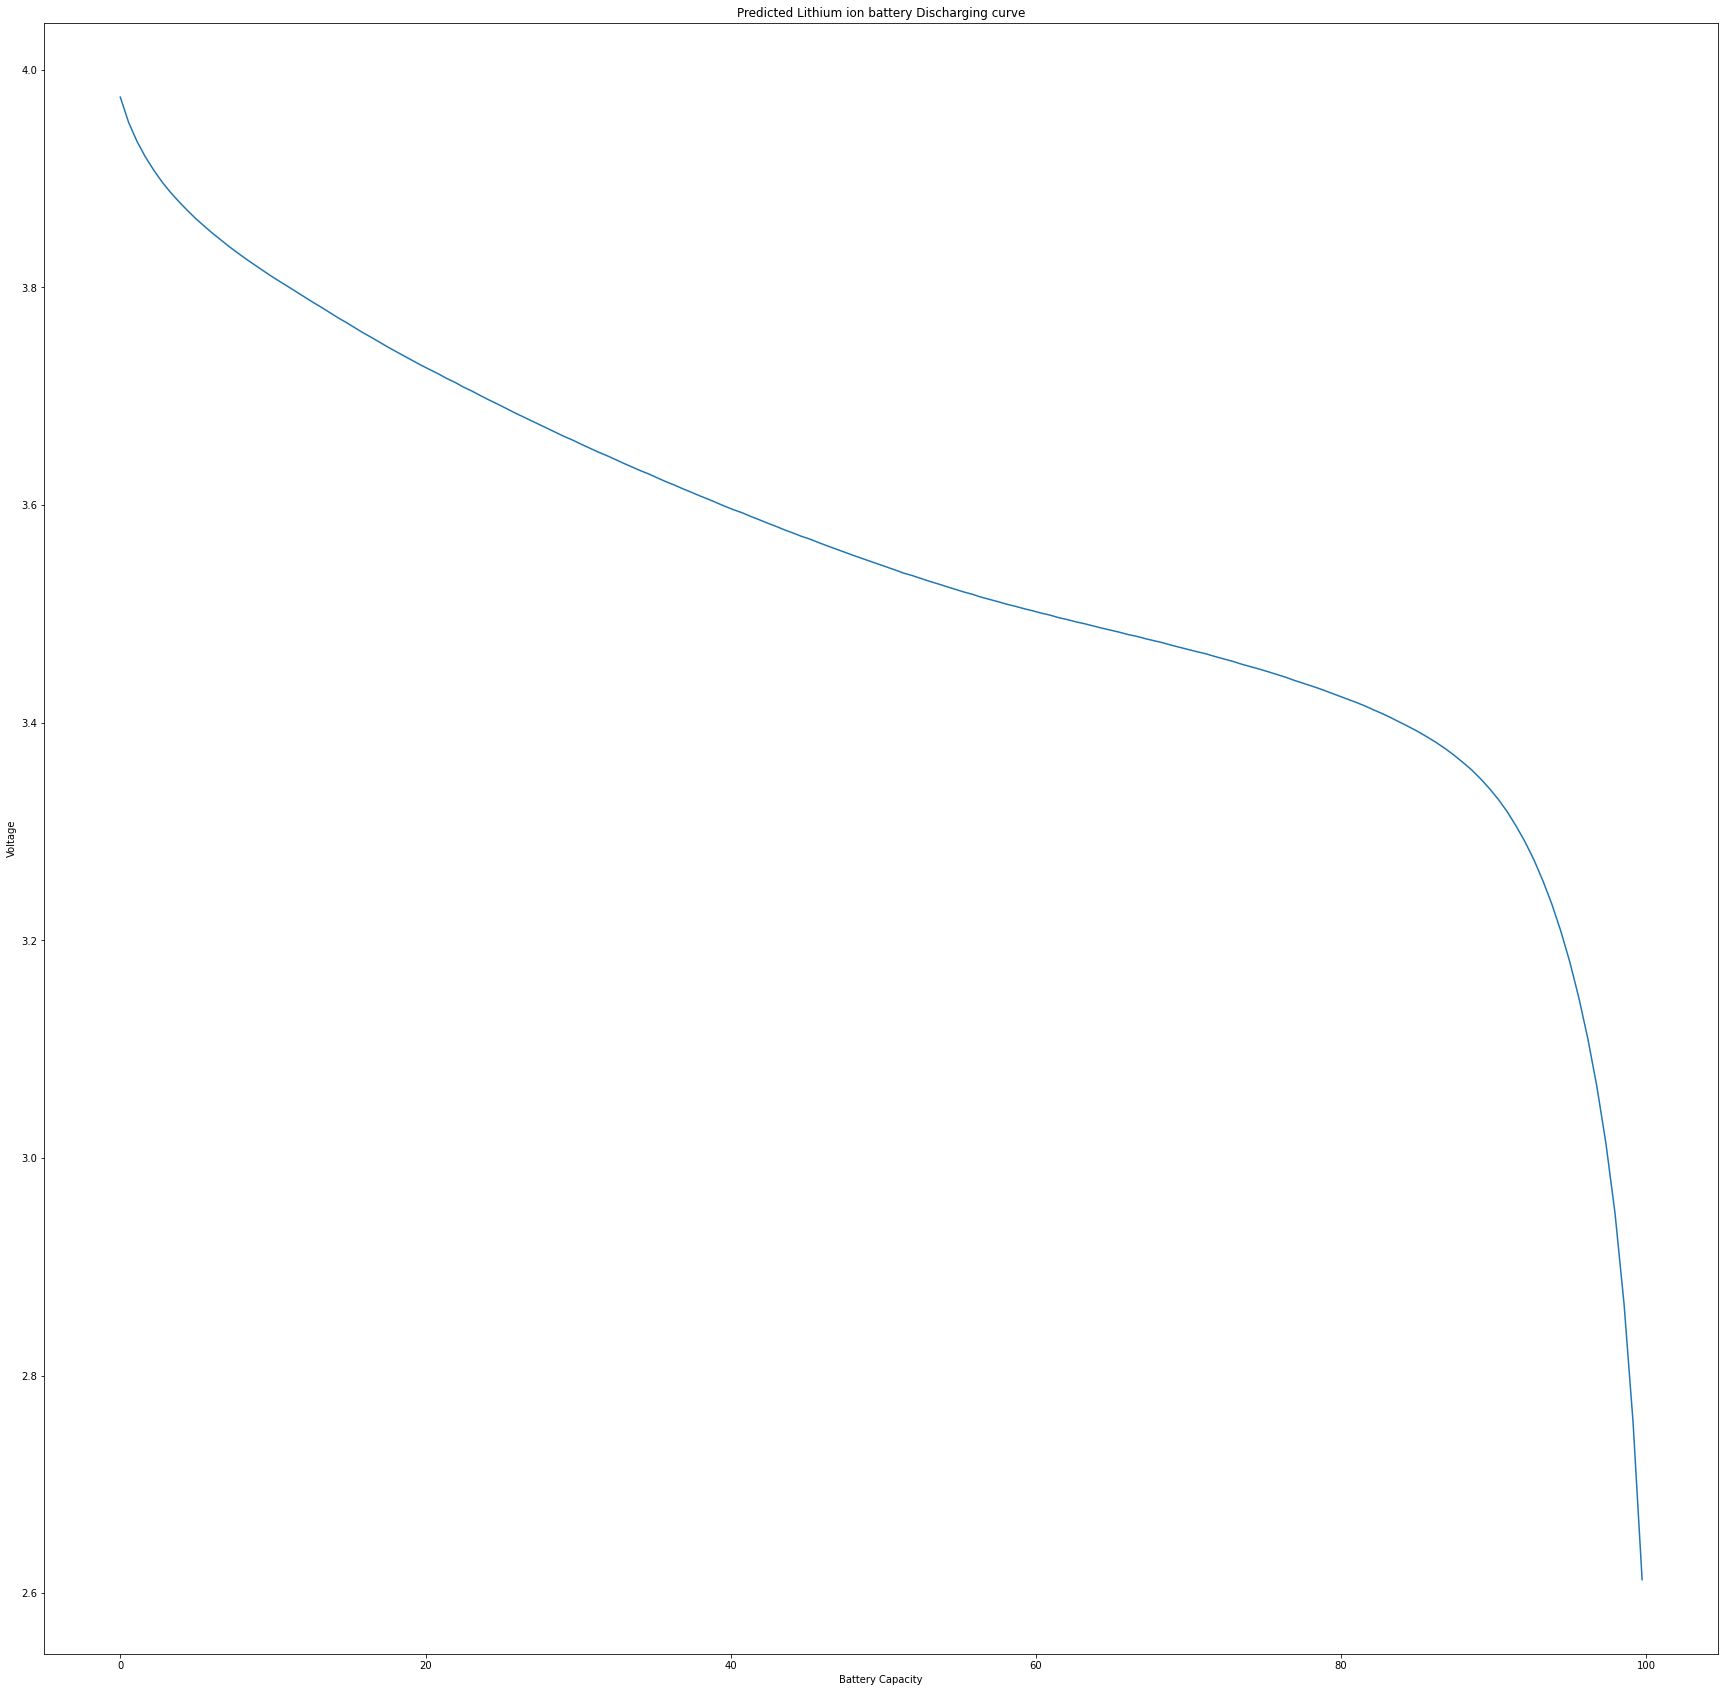

In [9]:
from matplotlib import pyplot as plt    
    
y = list(df['Voltage_measured'][0:178])    
x = SOC_remaining
print(len(SOC_List))
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)    
plt.plot(x,y)    
    
plt.title("Predicted Lithium ion battery Discharging curve")    
plt.ylabel('Voltage')    
plt.xlabel('Battery Capacity')    
plt.show() 

In [10]:
N = 178
dV_dC = [0]
for i in range(1, N):
    ele = (df['Voltage_measured'][i] - df['Voltage_measured'][i-1])/(SOC_remaining[i] - SOC_remaining[i-1])
    dV_dC.append(ele)
    

178


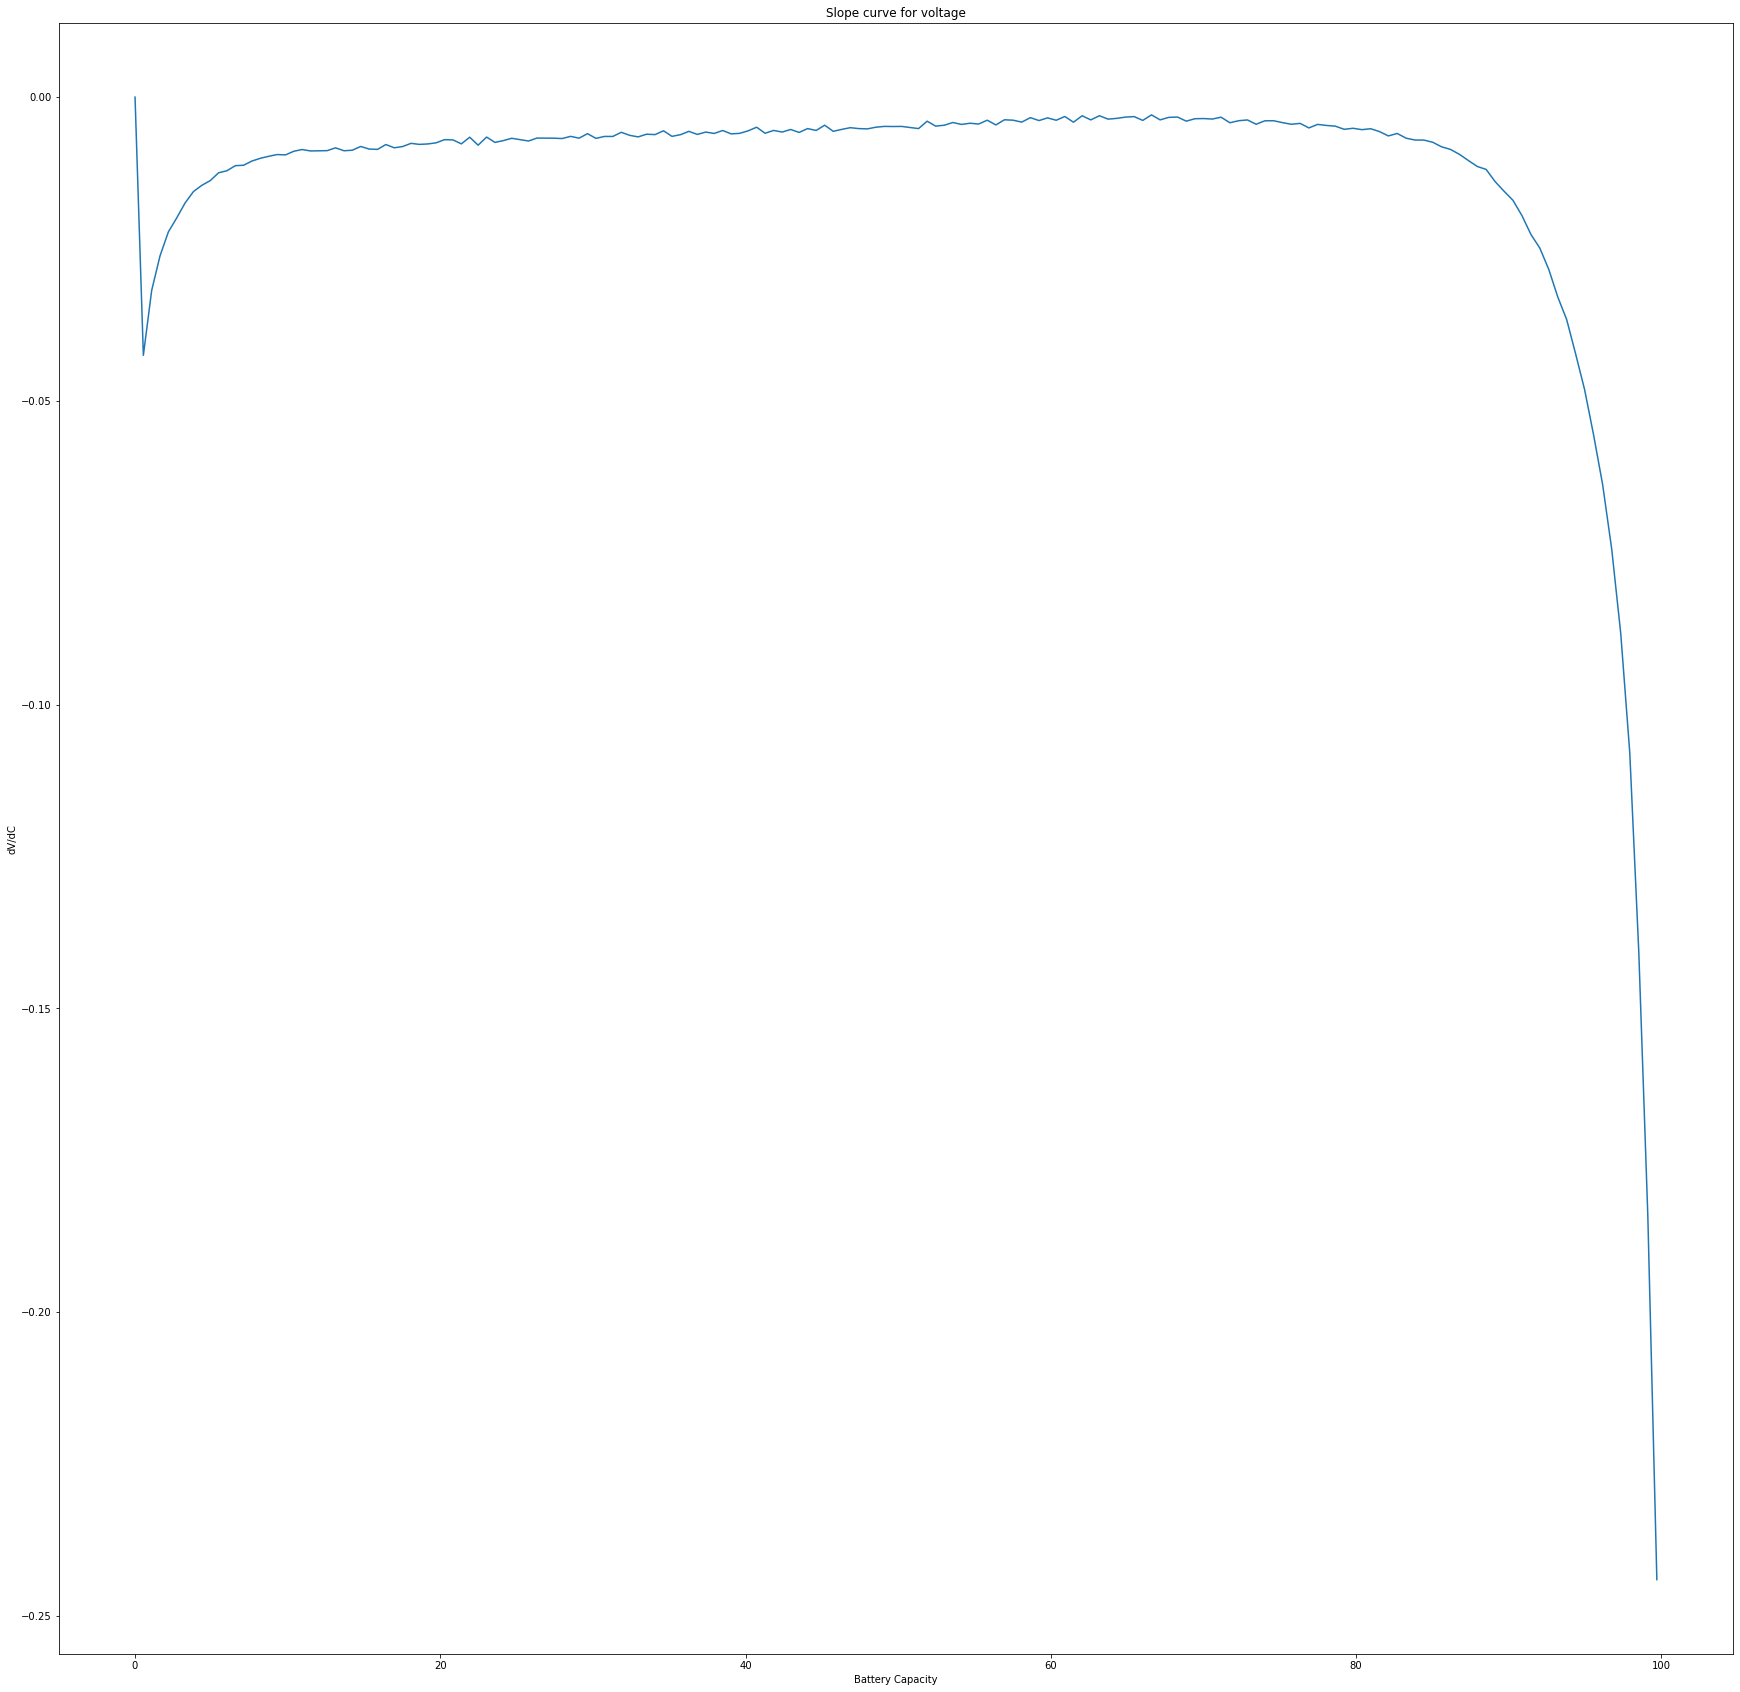

In [11]:
from matplotlib import pyplot as plt    
    
y = dV_dC   
x = SOC_remaining
print(len(SOC_List))
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)    
plt.plot(x,y)    
    
plt.title("Slope curve for voltage")    
plt.ylabel('dV/dC')    
plt.xlabel('Battery Capacity')    
plt.show() 

In [12]:

proposedSOC = []

def getCapacity(start, end, df):
    lst = []
    rsArea = 0
    for n in range(start+1, end):
        timeDiff = abs(df['Time'][n] - df['Time'][n-1])
        if(timeDiff > 25):
            timeDiff = sum(lst)/len(lst)
        lst.append(timeDiff)
        rsArea = rsArea + abs(timeDiff*df['Current_measured'][n])
    return rsArea

for i in range(0, len(cycleIndex)-1):
    start = cycleIndex[i]
    end = cycleIndex[i+1]
    proposedSOC.append(100)
    Capacity = getCapacity(start, end, df)
    for n in range(start+1, end):
        timeDiff = df['Time'][n] - df['Time'][n-1]
        if(timeDiff > 25):
            timeDiff = sum(lst)/len(lst)
        SOC_n = proposedSOC[n-1] + df['Current_measured'][n]*(abs(timeDiff))*100/Capacity
        proposedSOC.append(SOC_n)
print(df['Current_measured'])

0        -2.012528
1        -2.013979
2        -2.011144
3        -2.013007
4        -2.014400
            ...   
169761   -2.011160
169762   -2.011370
169763   -2.010542
169764   -2.011117
169765   -2.011110
Name: Current_measured, Length: 169766, dtype: float64


In [13]:
df['SOC'] = proposedSOC
df

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Battery,SOC
0,3.974871,-2.012528,24.389085,1.9982,3.062,35.703,1.856487,1,discharge,24,2008,B0005,1.000000e+02
1,3.951717,-2.013979,24.544752,1.9982,3.030,53.781,1.856487,1,discharge,24,2008,B0005,9.945367e+01
2,3.934352,-2.011144,24.731385,1.9982,3.011,71.922,1.856487,1,discharge,24,2008,B0005,9.890621e+01
3,3.920058,-2.013007,24.909816,1.9982,2.991,90.094,1.856487,1,discharge,24,2008,B0005,9.835731e+01
4,3.907904,-2.014400,25.105884,1.9982,2.977,108.281,1.856487,1,discharge,24,2008,B0005,9.780757e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169761,2.835283,-2.011160,37.396003,1.9986,1.937,2392.437,1.341051,132,discharge,24,2008,B0018,2.282085e+00
169762,2.774711,-2.011370,37.544067,1.9986,1.880,2406.250,1.341051,132,discharge,24,2008,B0018,1.711448e+00
169763,2.690974,-2.010542,37.723665,1.9986,1.806,2420.062,1.341051,132,discharge,24,2008,B0018,1.141087e+00
169764,2.566085,-2.011117,37.925675,1.9986,1.698,2433.890,1.341051,132,discharge,24,2008,B0018,5.699021e-01


# Linear Regression Model for SOC prediction

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

data = df[['Current_measured', 'Temperature_measured', 'Voltage_measured', 'Capacity', 'SOC']]

In [15]:
data.head()

,Current_measured,Temperature_measured,Voltage_measured,Capacity,SOC
0,-2.012528,24.389085,3.974871,1.856487,100.000000
1,-2.013979,24.544752,3.951717,1.856487,99.453671
2,-2.011144,24.731385,3.934352,1.856487,98.906210
3,-2.013007,24.909816,3.920058,1.856487,98.357306
4,-2.014400,25.105884,3.907904,1.856487,97.807568


In [16]:
X = np.array(data[['Voltage_measured']])
y = np.array(data['SOC'])

data.dropna(inplace = True)
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.8119759017442261


C:\Users\SIDDHESH\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [17]:
y_pred = regr.predict(X)

In [18]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
  
mae = mean_absolute_error(y_true=y,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 9.51216108052897
MSE: 160.237079572818
RMSE: 12.658478564694022


169766


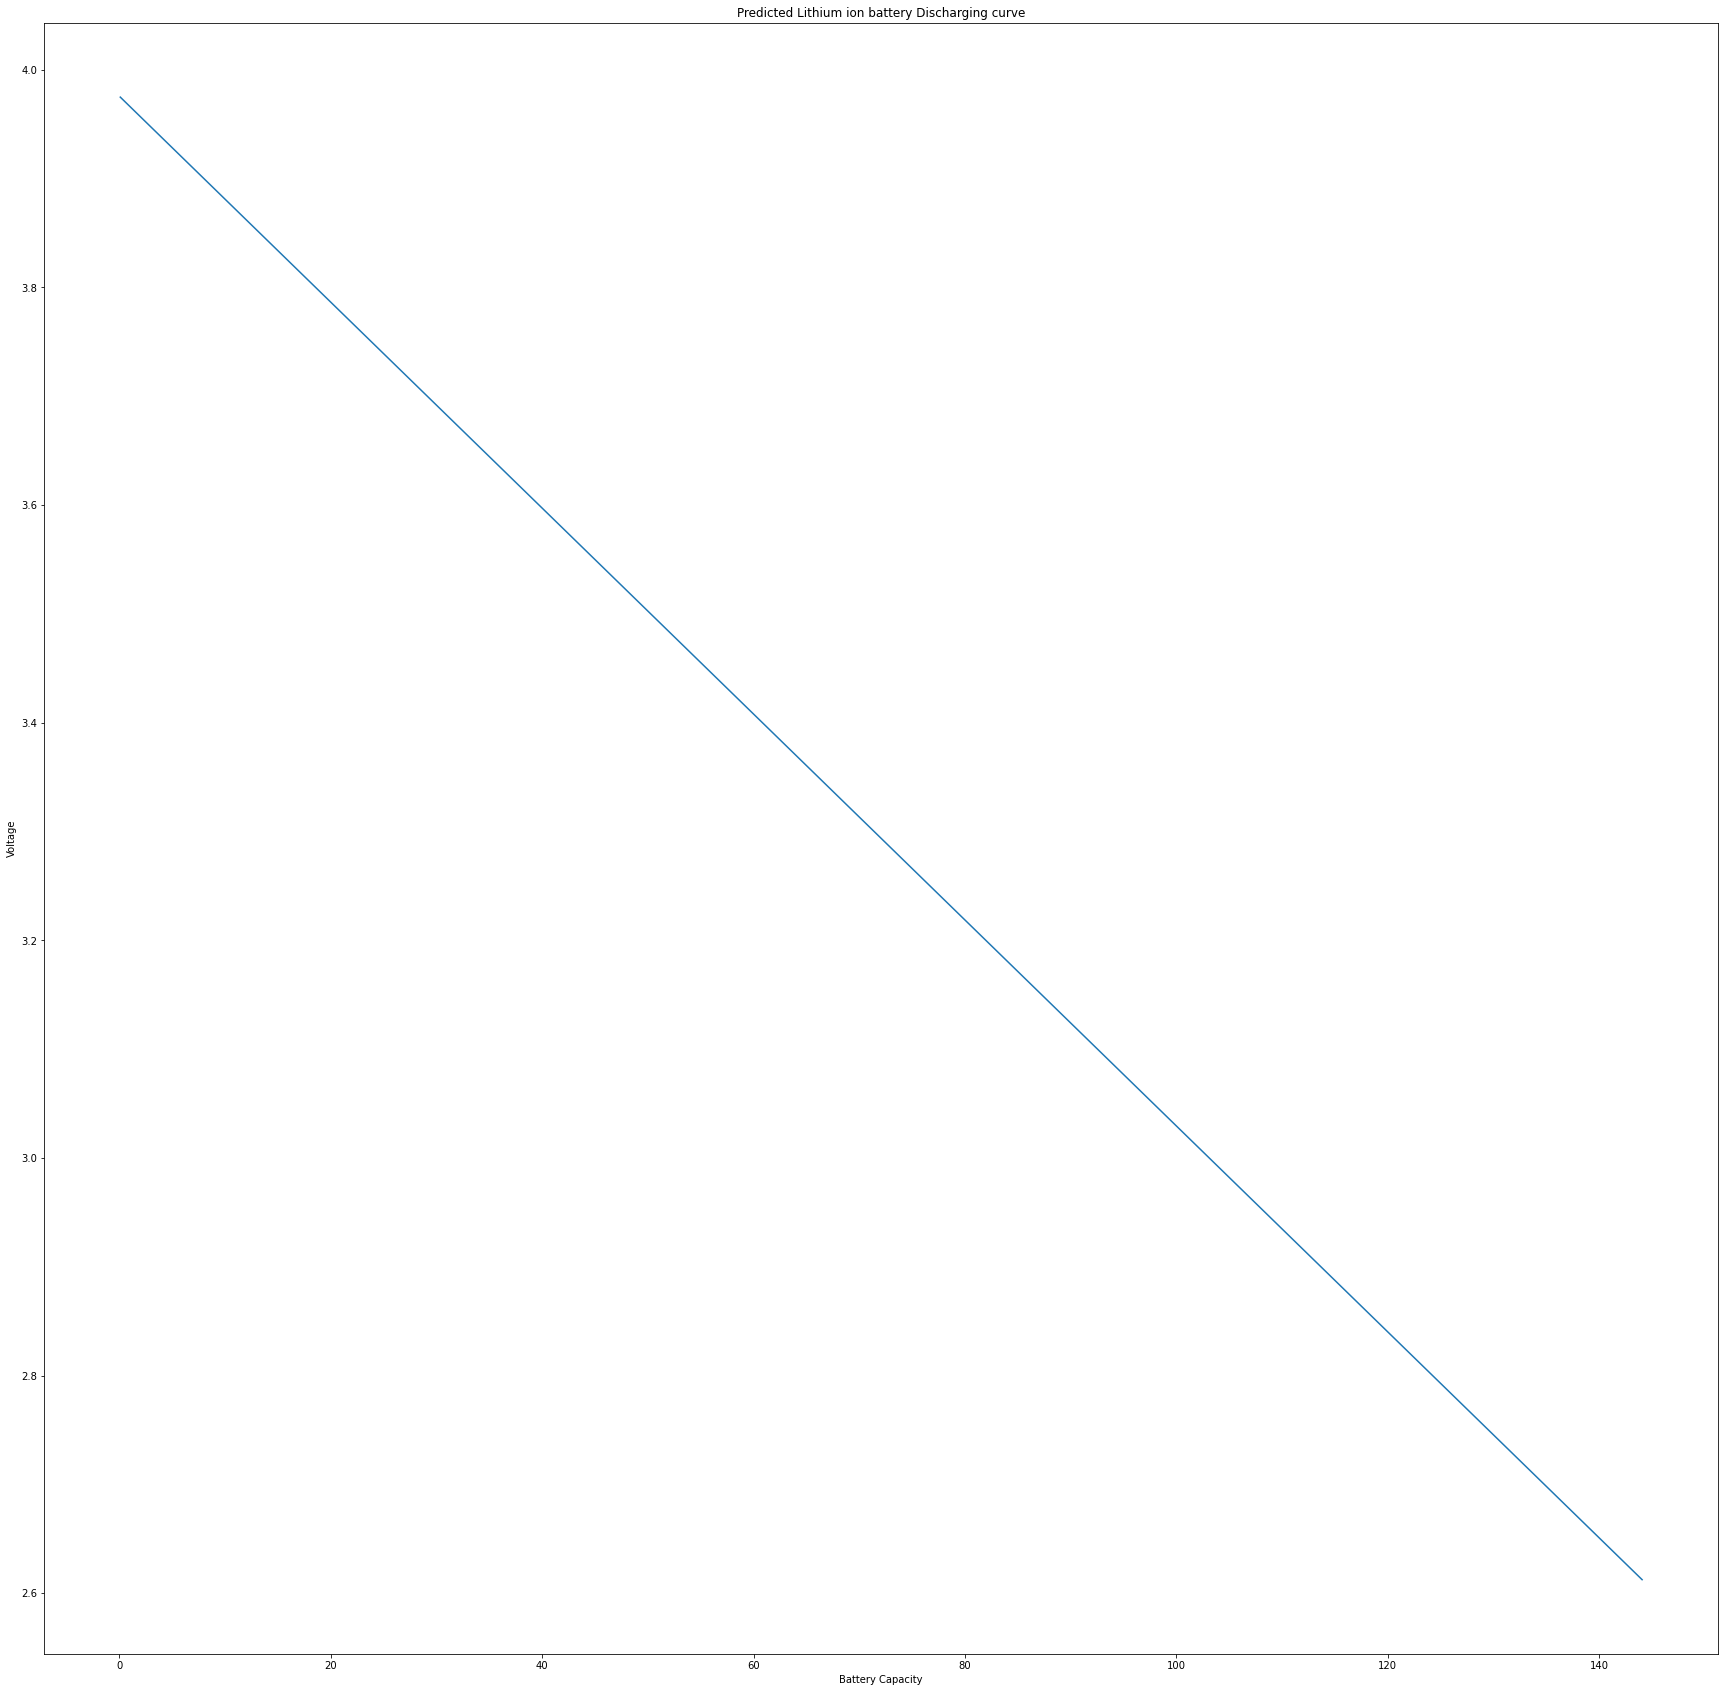

In [19]:
SOC_List = y_pred
SOC_remaining = []
for soc in SOC_List:
    SOC_remaining.append(100-soc)
from matplotlib import pyplot as plt    
    
y = list(df['Voltage_measured'][0:178])    
x = SOC_remaining[0:178]
print(len(SOC_List))
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)    
plt.plot(x,y)    
    
plt.title("Predicted Lithium ion battery Discharging curve")    
plt.ylabel('Voltage')    
plt.xlabel('Battery Capacity')    
plt.show() 

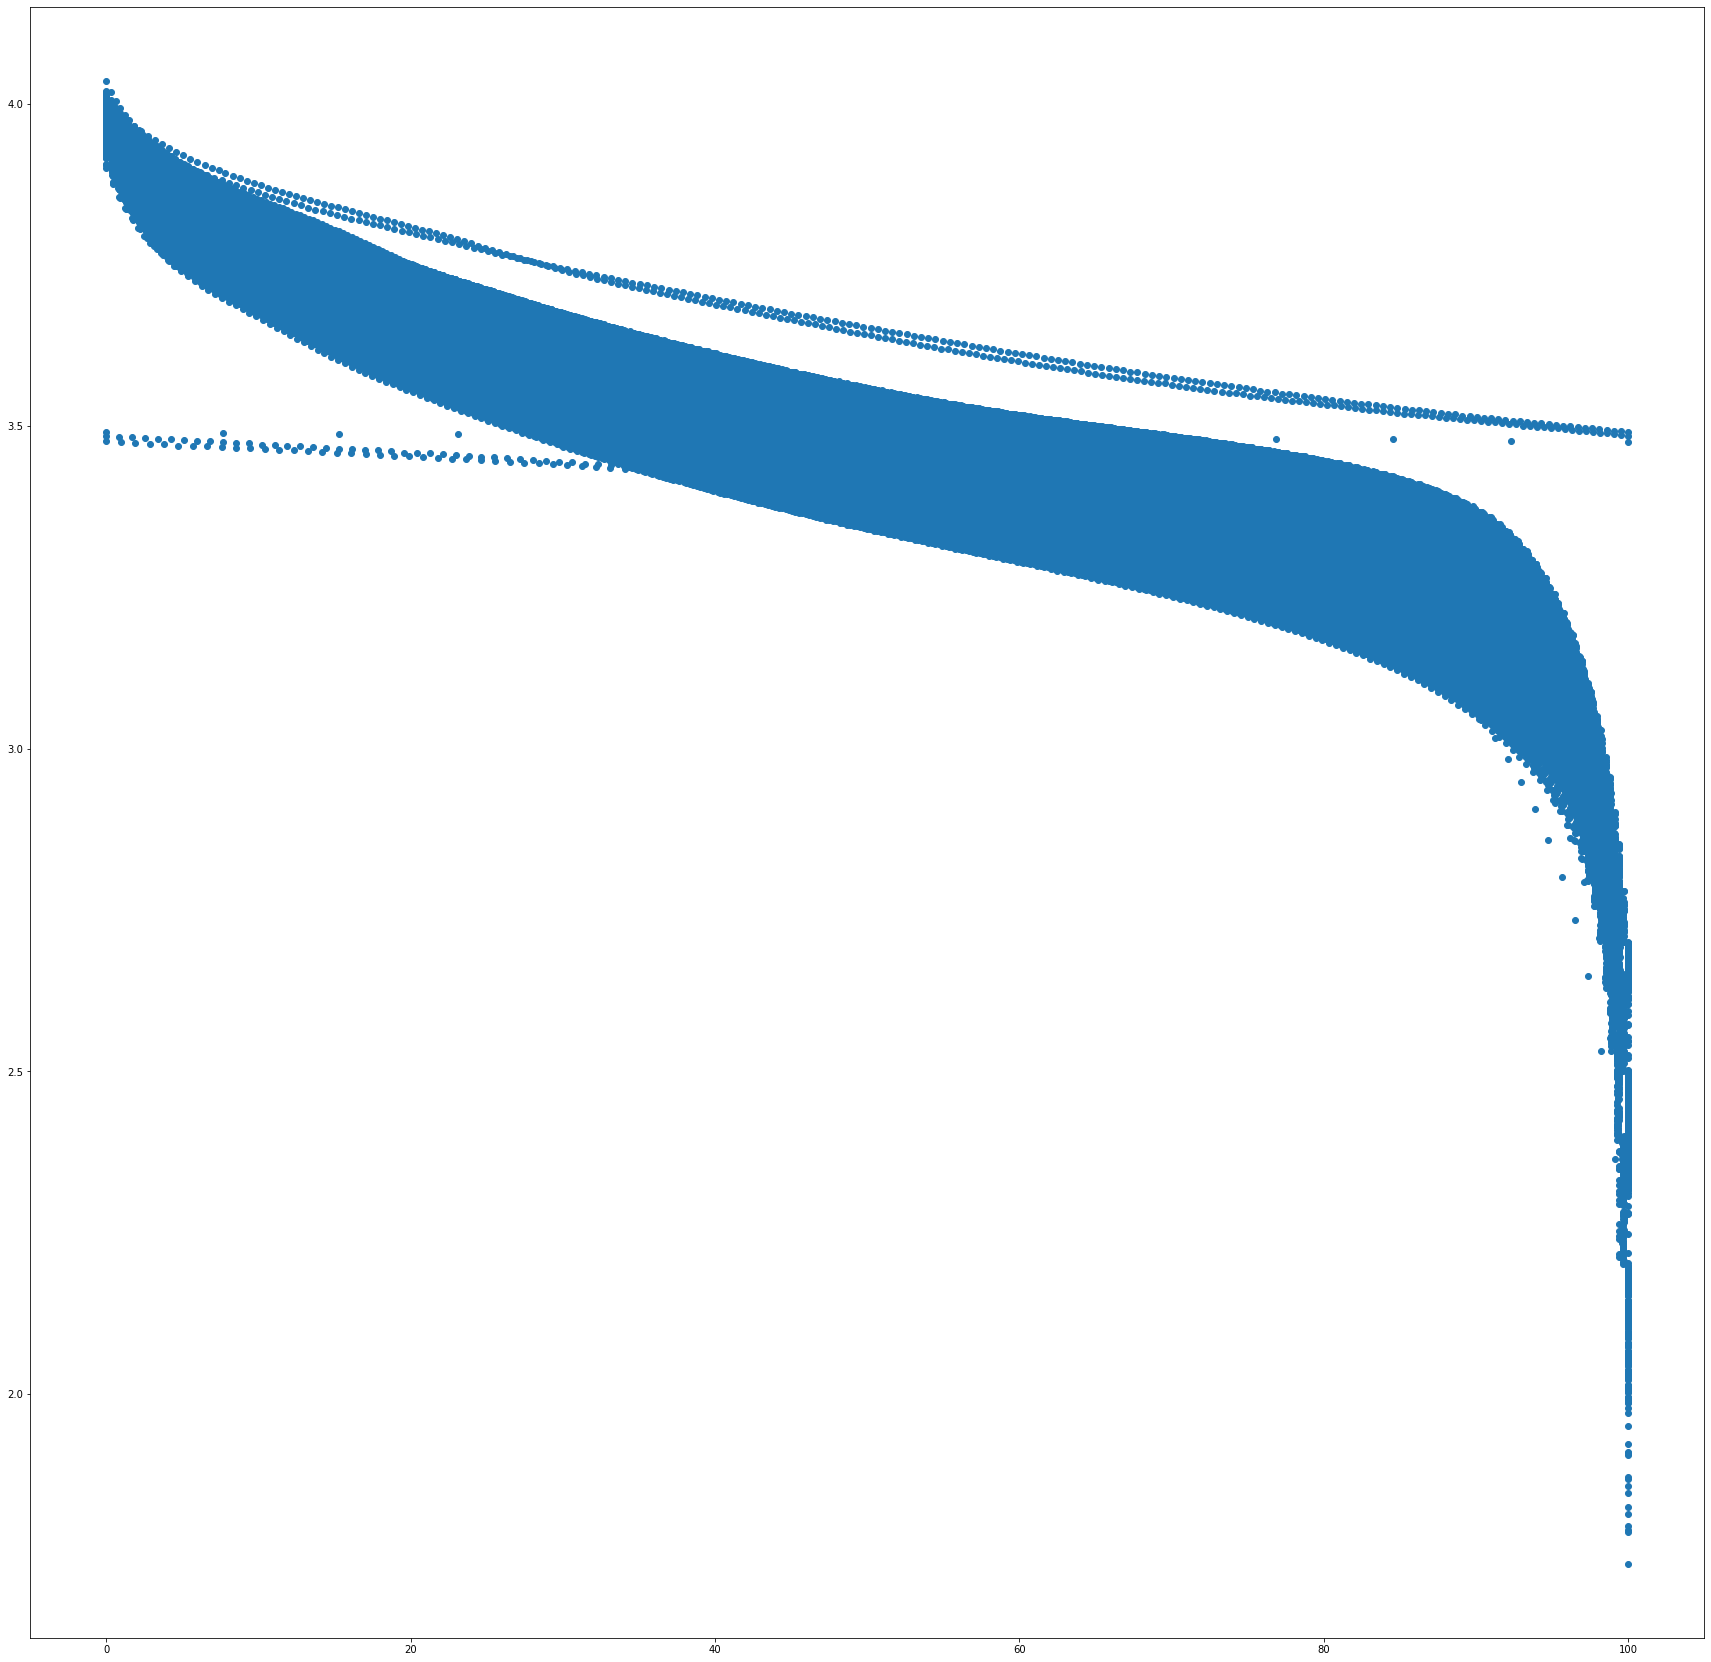

In [20]:
import matplotlib.pyplot as plt
start = cycleIndex[0]
end = cycleIndex[-1]

y = df['Voltage_measured'][start:end]
x = df['SOC'][start:end]

for i in range(0, len(cycleIndex)-1):
    l = cycleIndex[i]
    h = cycleIndex[i+1] - 1
    if(x[h] < x[l]):
        for j in range(l,h+1):
            x[j] = 100 - x[j]
            


f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)
plt.scatter(x, y)


# AI Modeling for regioning curve

# 1. Unsupervised Learning for curve splitting

In [102]:
import math
import pandas as pd

regions = 5
df = pd.read_csv(r'D:\battery_aging\dischargeCC.csv')
voltageLevels = len(df['Voltage_measured']) 
SOC = df['SOC'] 
N = len(SOC[0:178])
print(N)

def squared_error(start, end, x, y):
    if(start == end or x[end] == x[start]):
        return 0
    m = (y[end] - y[start])/(x[end] - x[start])
    c = y[end] - x[end]*m
    sq_err = 0
    for i in range(start, end+1):
        y_pred = x[i]*m + c
        y_actual = y[i]
        sq_err = sq_err + (y_pred - y_actual)**2
    return sq_err




178


In [103]:
##Find Minima, Maximas
def getExtremePoints(df, start, end ):
    minimaList = []
    maximaList = []
    extremaList = []

    for i in range(start,end):
        if(i == start):
            if(df['Voltage_measured'][i] < df['Voltage_measured'][i+1]):
                minimaList.append(i)
                extremaList.append(i)
            elif(df['Voltage_measured'][i] > df['Voltage_measured'][i+1]):
                maximaList.append(i)
                extremaList.append(i)
        elif(i == end-1):
            if(df['Voltage_measured'][i] < df['Voltage_measured'][i-1]):
                minimaList.append(i)
                extremaList.append(i)
            elif(df['Voltage_measured'][i] > df['Voltage_measured'][i-1]):
                maximaList.append(i)
                extremaList.append(i)
        else:
            if(df['Voltage_measured'][i] < df['Voltage_measured'][i-1] and df['Voltage_measured'][i] < df['Voltage_measured'][i+1]):
                minimaList.append(i)
                extremaList.append(i)
            elif(df['Voltage_measured'][i] > df['Voltage_measured'][i-1] and df['Voltage_measured'][i] > df['Voltage_measured'][i+1]):
                maximaList.append(i)
                extremaList.append(i)
    return extremaList

# 1.a Curve splitting

In [139]:
#find point of inflection
#here we have only one minima and maxima
def unsupervisedSplitter(df,start, end):
    extremaList =  getExtremePoints(df, start, end)
    op = [0]
    inflectionList = []
    for i in range(0, len(extremaList)-1):

        p1 = extremaList[i]
        p2 = extremaList[i+1]
        m = (df['Voltage_measured'][p1] - df['Voltage_measured'][p2])/(SOC[p1] - SOC[p2])
        c = df['Voltage_measured'][p1] - m*SOC[p1]
        prevDist = 0
        for i in range(p1+1, p2-1):
            y = df['Voltage_measured'][i]
            dist = y - (m*SOC[i] + c)
            if(dist*prevDist < 0):
                inflectionList.append(i)
            prevDist = dist
    if(len(inflectionList) == 0):
        op[0] = -1
        return op

    I = inflectionList[0] 
    op.append(I)
        #determining point in the middle
    minError = squared_error(I, extremaList[1] , SOC, df['Voltage_measured'])
    splitPoint = I
    for i in range(I, extremaList[-1]):
        error = squared_error(I,  i, SOC, df['Voltage_measured']) + squared_error(i+1,  extremaList[-1], SOC, df['Voltage_measured'])
#        print(minError)
        if(error < 0.001):
            continue
        if(error < minError):
            minError = error
            splitPoint = i
            
    op.append(splitPoint)
    I = splitPoint
    minError = squared_error(I, extremaList[1] , SOC, df['Voltage_measured'])
    for i in range(I+1, extremaList[-1]):
        error = squared_error(I,  i, SOC, df['Voltage_measured']) + squared_error(i+1,  extremaList[-1], SOC, df['Voltage_measured'])
        if(error < 0.001):
            continue
        if(error < minError):
            minError = error
            splitPoint = i
#        print(minError)
    op.append(splitPoint)
    op.append(end)
    return op
start, end = cycleIndex[39], cycleIndex[40]
op = unsupervisedSplitter(df,start, end-1 )

    
import matplotlib.pyplot as plt

y = df['Voltage_measured'][start:end]
x = df['SOC'][start:end]
print(len(x), len(y))

339 339


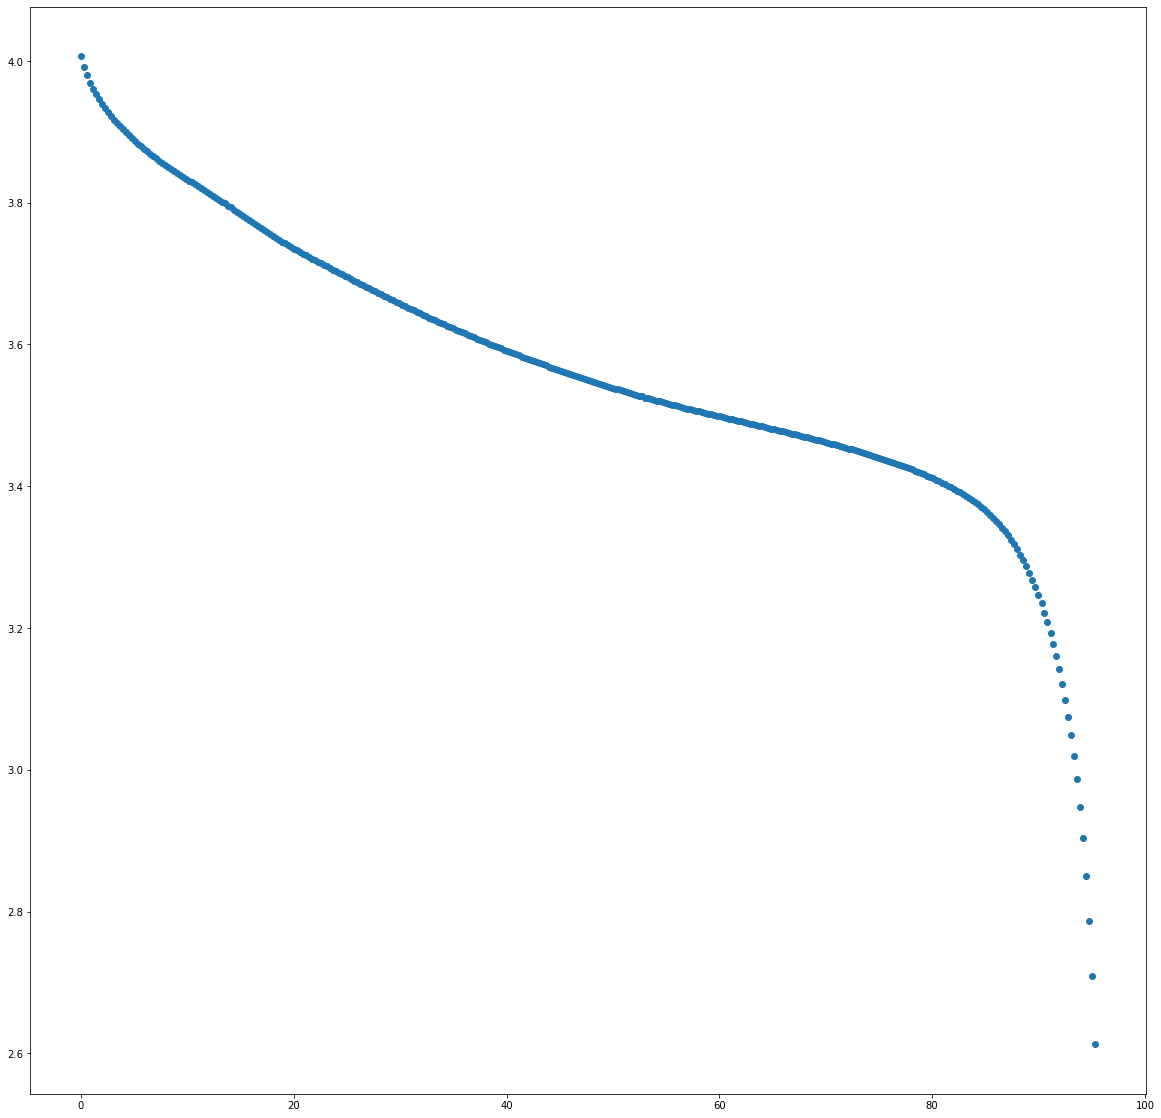

In [140]:
import matplotlib.pyplot as plt


f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
plt.scatter(x, y)

In [141]:
print(cycleIndex[-1])

169766


# 1.b Labeling

In [215]:
Labels = ['A', 'B', 'C', 'D']
category = []
for i in range(0, len(cycleIndex)-1):
    start = cycleIndex[i]
    if(start != 0):
        start = start + 1
    end = cycleIndex[i+1]
    op = unsupervisedSplitter(df,start, end-1)
    if(len(op) == 1 and op[0] == -1):
        for charge in SOC[start:end+1]:
            category.append(None)
        while(len(category) == end-2):
            category.append(None)
        continue
    for charge in SOC[start:end]:
        for j in range(0, 4):
            if(SOC[op[j]] <= charge and charge < SOC[op[j+1]]):
                category.append(Labels[j])
                break
    while(len(category) < end):
        category.insert(end,'D')
    if(i%100 == 0 ):
        print(i)

0
100
200
300
400
500
600


In [216]:
df['category'] = category

In [219]:
df.to_csv(r'D:\battery_aging\temp.csv', header=False, index=False)